In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import datetime as dt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [23]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv("/content/drive/My Drive/KMMI/ausmi_bulan.csv",usecols=[0,1],engine='python')
data['Waktu'] = pd.to_datetime(data['Waktu'])
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Waktu,ausmi
0,1948-01-01,-1.615
1,1948-02-01,-0.289
2,1948-03-01,-0.992
3,1948-04-01,-1.260
4,1948-05-01,-3.673


In [16]:
dataset=data['ausmi']
dataset=dataset.values

# normalize the dataset
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(-1,1))
dataset=scaler.fit_transform(dataset)
print(dataset.shape)

(876, 1)


In [17]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape)
print(test.shape)

(700, 1)
(176, 1)


In [50]:
#input sampling timeseries
look_back = 12
#define param
n = look_back
m = 30
N = 1
learning_rate = 0.0001
TRAIN_ITER = 1000
activation='tanh'

#Create Dataset Function
def create_dataset(dataset,look_back):
  X,Y=[],[]
  for i in range (len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    X.append(a)
    Y.append(dataset[i+look_back,0])
  return np.array(X),np.array(Y)

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

opt = keras.optimizers.Adam(learning_rate=learning_rate)

# define model
model = Sequential()
model.add(Dense(m, input_dim = n, activation=activation))
model.add(Dense(N, activation='linear'))
model.compile(optimizer=opt, loss='mean_squared_error')
history=model.fit(trainX, trainY, epochs=TRAIN_ITER, batch_size=1, validation_data=(testX,testY),
          callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=2, shuffle=False)

# make predictions
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

#MAPE
def mean_absolute_percentage_error (testY,testPredict) :
  testY, testPredict=np.array(testY),np.array(testPredict)
  return np.mean(np.abs((testY-testPredict)/testY))*100
MAPE=mean_absolute_percentage_error (testY,testPredict)
print('Test Score: %.2f MAPE' % (MAPE))

from sklearn.metrics import r2_score
testY = np.transpose(testY)
testY.shape
def my_r2_score(testY,testPredict):
  y_bar = np.mean(testY)
  ss_total = np.sum((testY - y_bar)**2)
  ss_explained = np.sum((testPredict - y_bar)**2)
  ss_residual = np.sum((testY - testPredict)**2)
  scikit_r2 = r2_score(testY, testPredict)
  print(f'R-squared (SS_explained / SS_Total) = {ss_explained / ss_total}\n' + \
          f'R-squared (1 - (SS_residual / SS_Total)) = {1 - (ss_residual / ss_total)}\n'+ \
          f"Scikit-Learn's R-squared = {scikit_r2}")


print('Positive R-squared\n')
my_r2_score(testY, testPredict)

Epoch 1/1000
687/687 - 2s - loss: 0.1246 - val_loss: 0.0484 - 2s/epoch - 2ms/step
Epoch 2/1000
687/687 - 1s - loss: 0.0677 - val_loss: 0.0408 - 923ms/epoch - 1ms/step
Epoch 3/1000
687/687 - 1s - loss: 0.0585 - val_loss: 0.0367 - 1s/epoch - 2ms/step
Epoch 4/1000
687/687 - 1s - loss: 0.0540 - val_loss: 0.0345 - 895ms/epoch - 1ms/step
Epoch 5/1000
687/687 - 1s - loss: 0.0519 - val_loss: 0.0333 - 1s/epoch - 2ms/step
Epoch 6/1000
687/687 - 1s - loss: 0.0508 - val_loss: 0.0327 - 920ms/epoch - 1ms/step
Epoch 7/1000
687/687 - 1s - loss: 0.0503 - val_loss: 0.0323 - 942ms/epoch - 1ms/step
Epoch 8/1000
687/687 - 1s - loss: 0.0500 - val_loss: 0.0321 - 1s/epoch - 2ms/step
Epoch 9/1000
687/687 - 1s - loss: 0.0499 - val_loss: 0.0319 - 1s/epoch - 2ms/step
Epoch 10/1000
687/687 - 1s - loss: 0.0498 - val_loss: 0.0318 - 1s/epoch - 2ms/step
Epoch 11/1000
687/687 - 1s - loss: 0.0497 - val_loss: 0.0318 - 982ms/epoch - 1ms/step
Epoch 12/1000
687/687 - 1s - loss: 0.0497 - val_loss: 0.0317 - 949ms/epoch - 1ms/

In [52]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 30)                390       
                                                                 
 dense_27 (Dense)            (None, 1)                 31        
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [53]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(687, 12)
(1, 687)
(163, 12)
(163, 1)


In [54]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

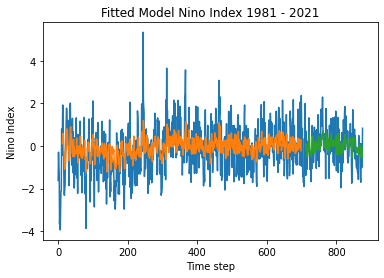

In [55]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Fitted Model Nino Index 1981 - 2021')
plt.xlabel('Time step')
plt.ylabel('Nino Index')
plt.show()

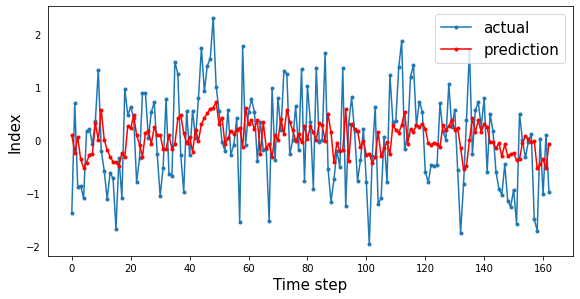

In [56]:
#Plot Prediction
aa=[x for x in range(163)]
plt.figure(figsize=(8,4))
plt.plot(aa,testY[:,0][:163],marker='.',label="actual")
plt.plot(aa,testPredict[:,0][:163],'r',marker='.',label="prediction")
plt.tick_params(left=False,labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Index',size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [51]:
X_FUTURE = 12
predictions = np.array([])
last = testX[-1]
for i in range(X_FUTURE):
  curr_prediction = model.predict(np.array([last]))
  last = np.concatenate([last[1:], curr_prediction[0]])
  predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = scaler.inverse_transform([predictions])[0]
print(predictions)

[-0.06479361 -0.10642497  0.05733657  0.01999878  0.14556172 -0.05626506
  0.02408136 -0.12534595 -0.23148536 -0.04212765 -0.12654226 -0.01839135]
